In [1]:
import sys
import numpy as np
import os.path as osp
import tensorflow as tf
import glob
import matplotlib.pylab as plt

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id

from general_tools.notebook.tf import reset_tf_graph                                              
from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k, indices_in_iterable

from geo_tool import Point_Cloud

from tf_lab.nips.shape_net import pc_loader as sn_pc_loader

from tf_lab.autopredictors.exploration import latent_embedding_of_entire_dataset

from tf_lab.autopredictors.evaluate import eval_model, read_saved_epochs

from tf_lab.nips.evaluate_gan import entropy_of_occupancy_grid, point_cloud_distances,\
                                     jensen_shannon_divergence, sample_pclouds_distances

from general_tools.strings import trim_content_after_last_dot

from general_tools.plotting import stack_images_in_square_grid

from tf_lab.nips.helper import pclouds_centered_and_half_sphere, zero_mean_half_sphere
import scipy.stats as stats

In [7]:
n_pc_samples = 2048
experiment_name = 'chair_conv_arch_1_2048pts_emd'
# experiment_name = class_name + '_conv_arch_1_2048pts_emd'
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)
conf = Conf.load(osp.join(train_dir, 'configuration'))
conf.n_output = conf.n_input
reset_tf_graph()

conf.allow_gpu_growth = True
ae = PointNetAutoEncoder(experiment_name, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
last_epoch = saved_epochs[-1]

ae.restore_model(conf.train_dir, last_epoch, verbose=True)

Model restored in epoch 1000.


In [5]:
class_name = raw_input('Give me the class type.\n').lower()
syn_id = shape_net_category_to_synth_id()[class_name]
print syn_id

Give me the class type.
chair
03001627


In [6]:
top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'Point_Clouds/Shape_Net/Core/from_manifold_meshes/centered/', str(n_pc_samples))

full_pclouds_path = osp.join(full_pclouds_path, syn_id)

train_dir = osp.join(top_data_dir, 'OUT/models/nips/vanilla_ae/')
train_dir = osp.join(train_dir, experiment_name)

In [8]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path, '.ply')
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names,\
                                                                           n_threads=40, loader=sn_pc_loader)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )


6778 files containing complete point clouds were found.


In [11]:
import matplotlib.pyplot as plt
from geo_tool import Point_Cloud

in_u_sphere_plotting = {'chair': True, 'airplane': False, 'cabinet': False, 'car': False, 'lamp': True, 'sofa': True, 'table': True, 'vessel': False}

azimuth_angles = {'chair': -50, 'airplane': 0, 'cabinet': -40, 'car': -60, 'lamp': 0, 'sofa': -60, 'table': 60, 'vessel': -60}

plotting_color = {'chair': 'g', 'airplane': 'b', 'cabinet': 'orange', 'car': 'r', 'lamp': 'yellow', 'sofa': 'magenta', 'table': [0.7, .45, 0], 'vessel': [0, 0.6, 1]}

from tf_lab.nips.data_sets.shape_net import shape_net_core_synth_id_to_category

def plotting_default_params(category):
    kwdict = {}
    kwdict['in_u_sphere'] = True
    kwdict['azim'] = 45
    try:
        kwdict['azim'] = azimuth_angles[category]
        kwdict['color'] = plotting_color[category]
    except:
        pass
    return kwdict


def plot_interpolations(inter_clouds, grid_size, fig_size=(50, 50), plot_conf={}):
    fig = plt.figure(figsize=fig_size)
    c = 1
    for cloud in inter_clouds:
        plt.subplot(grid_size[0], grid_size[1], c, projection='3d')
        plt.axis('off')
        ax = fig.axes[c - 1]
        Point_Cloud(points=cloud).plot(axis=ax, show=False, **plot_conf)
        c += 1
    return fig


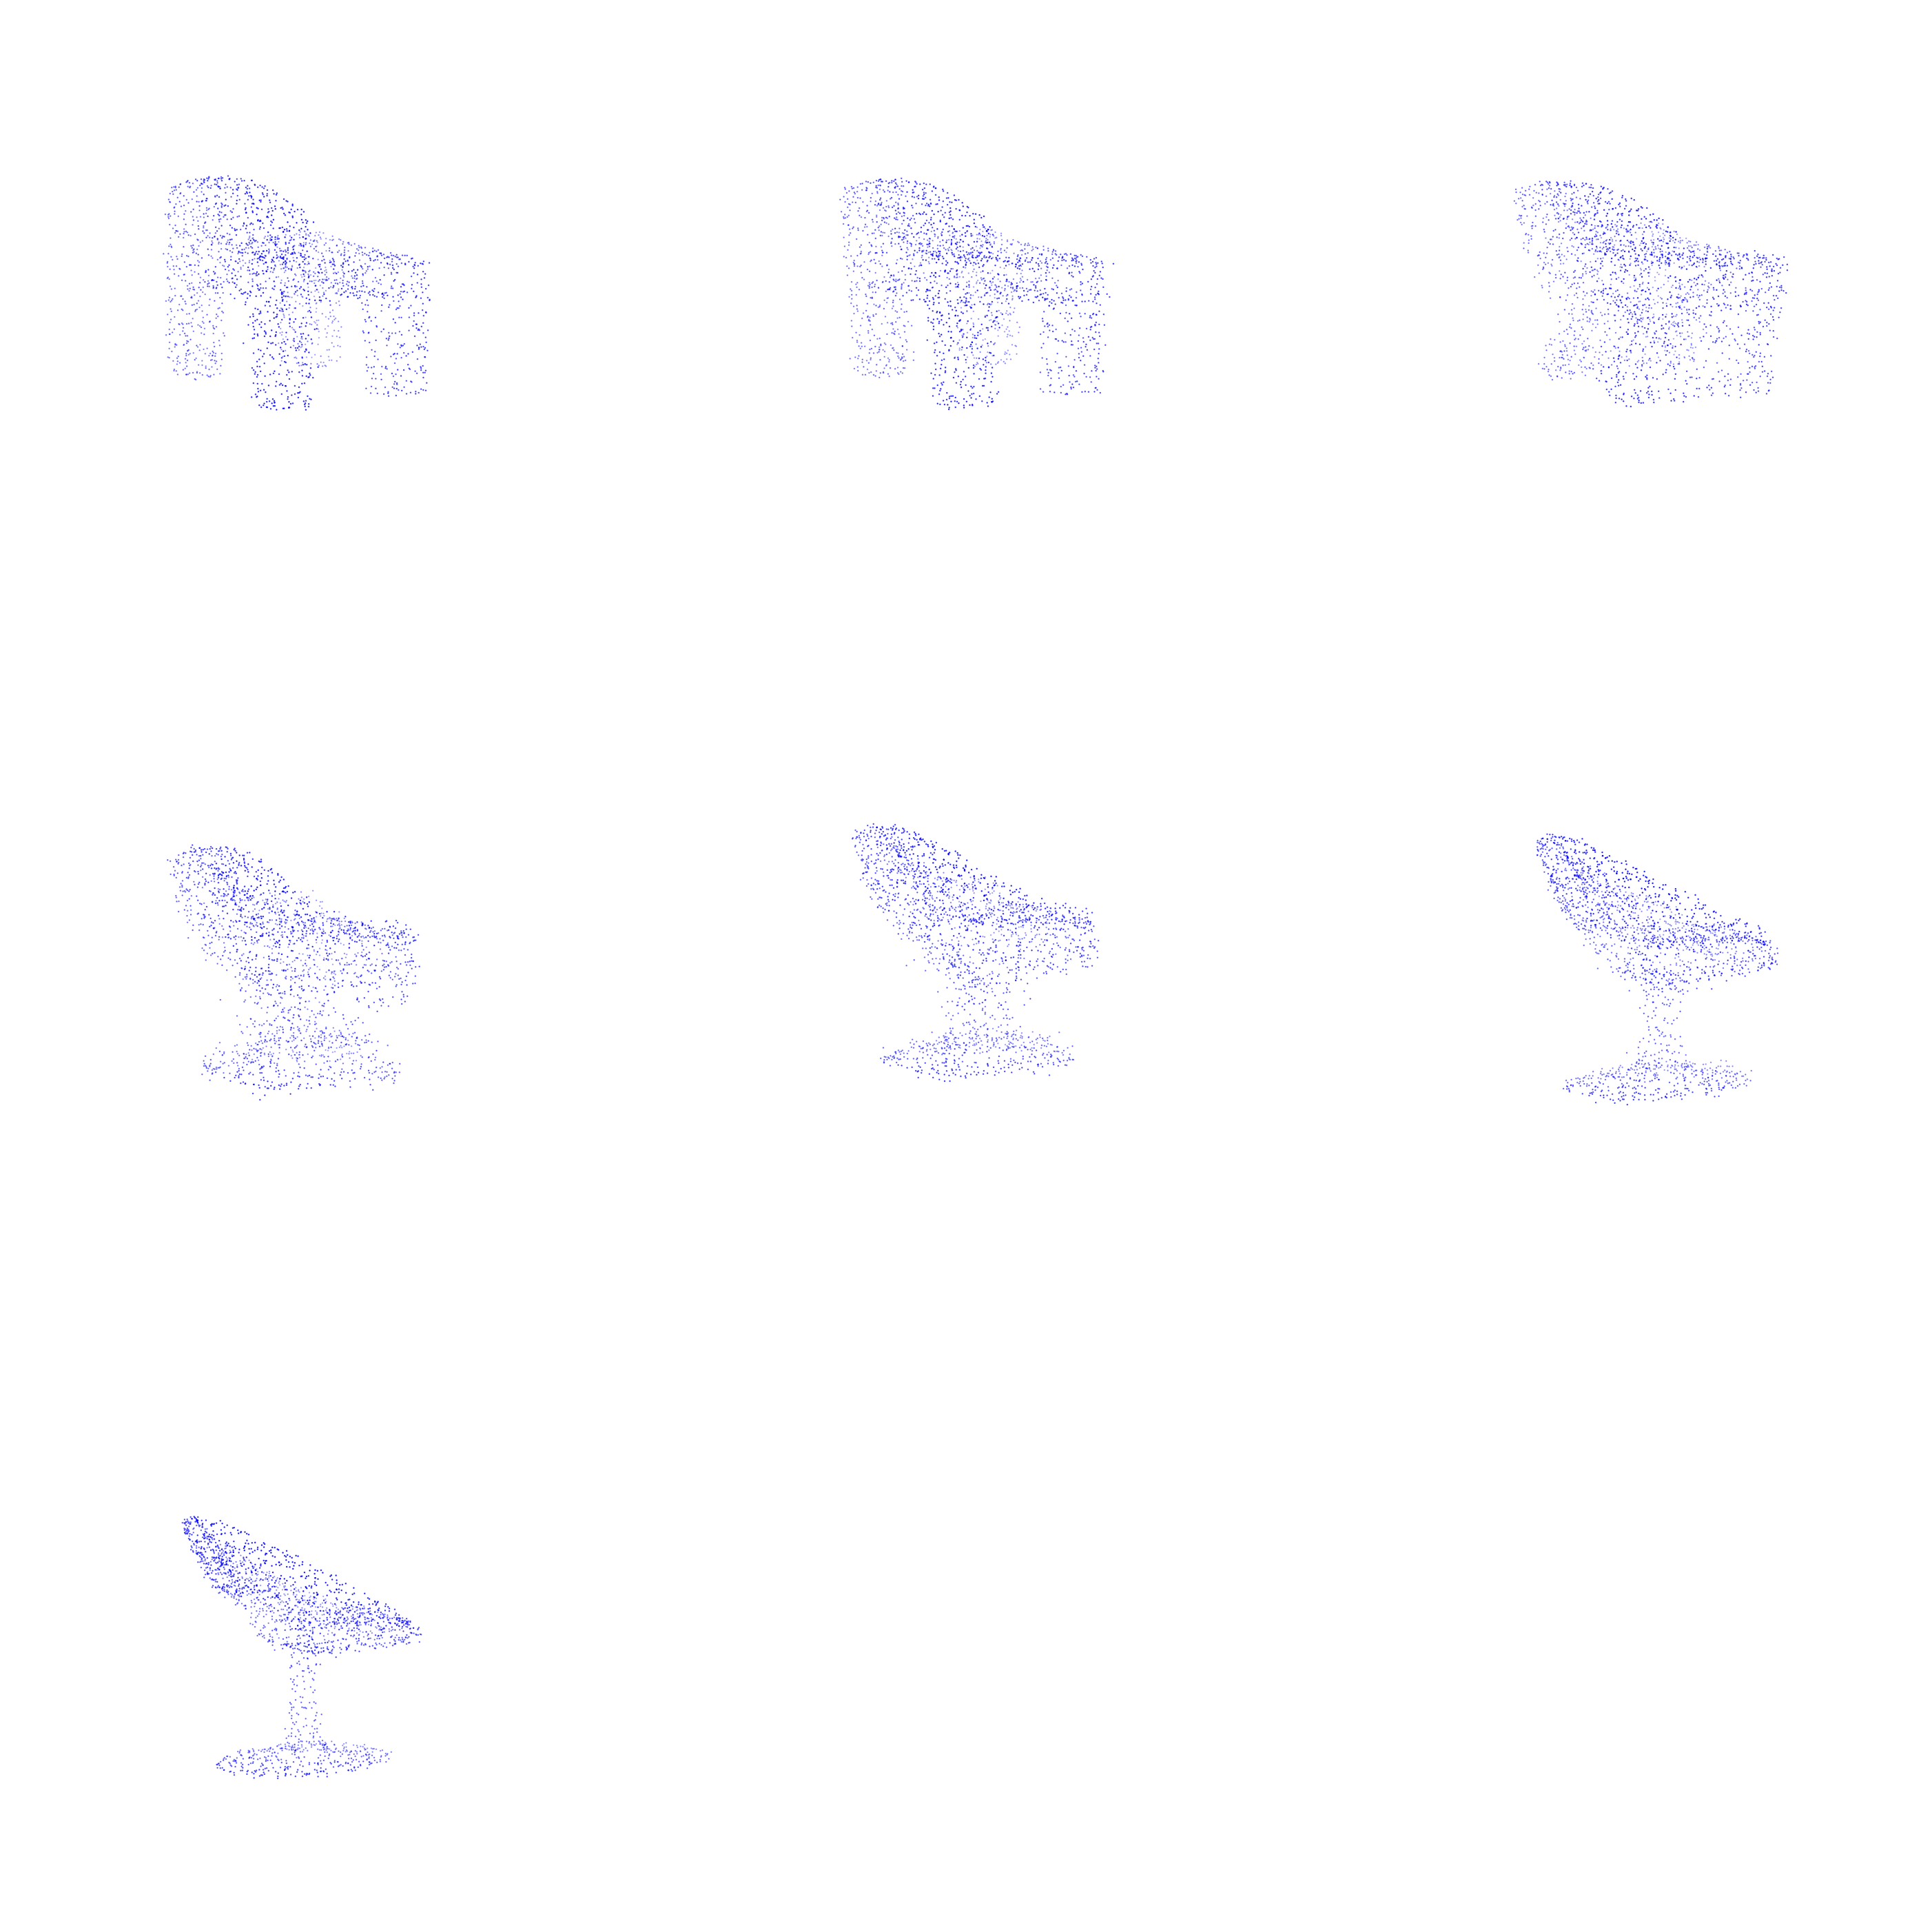

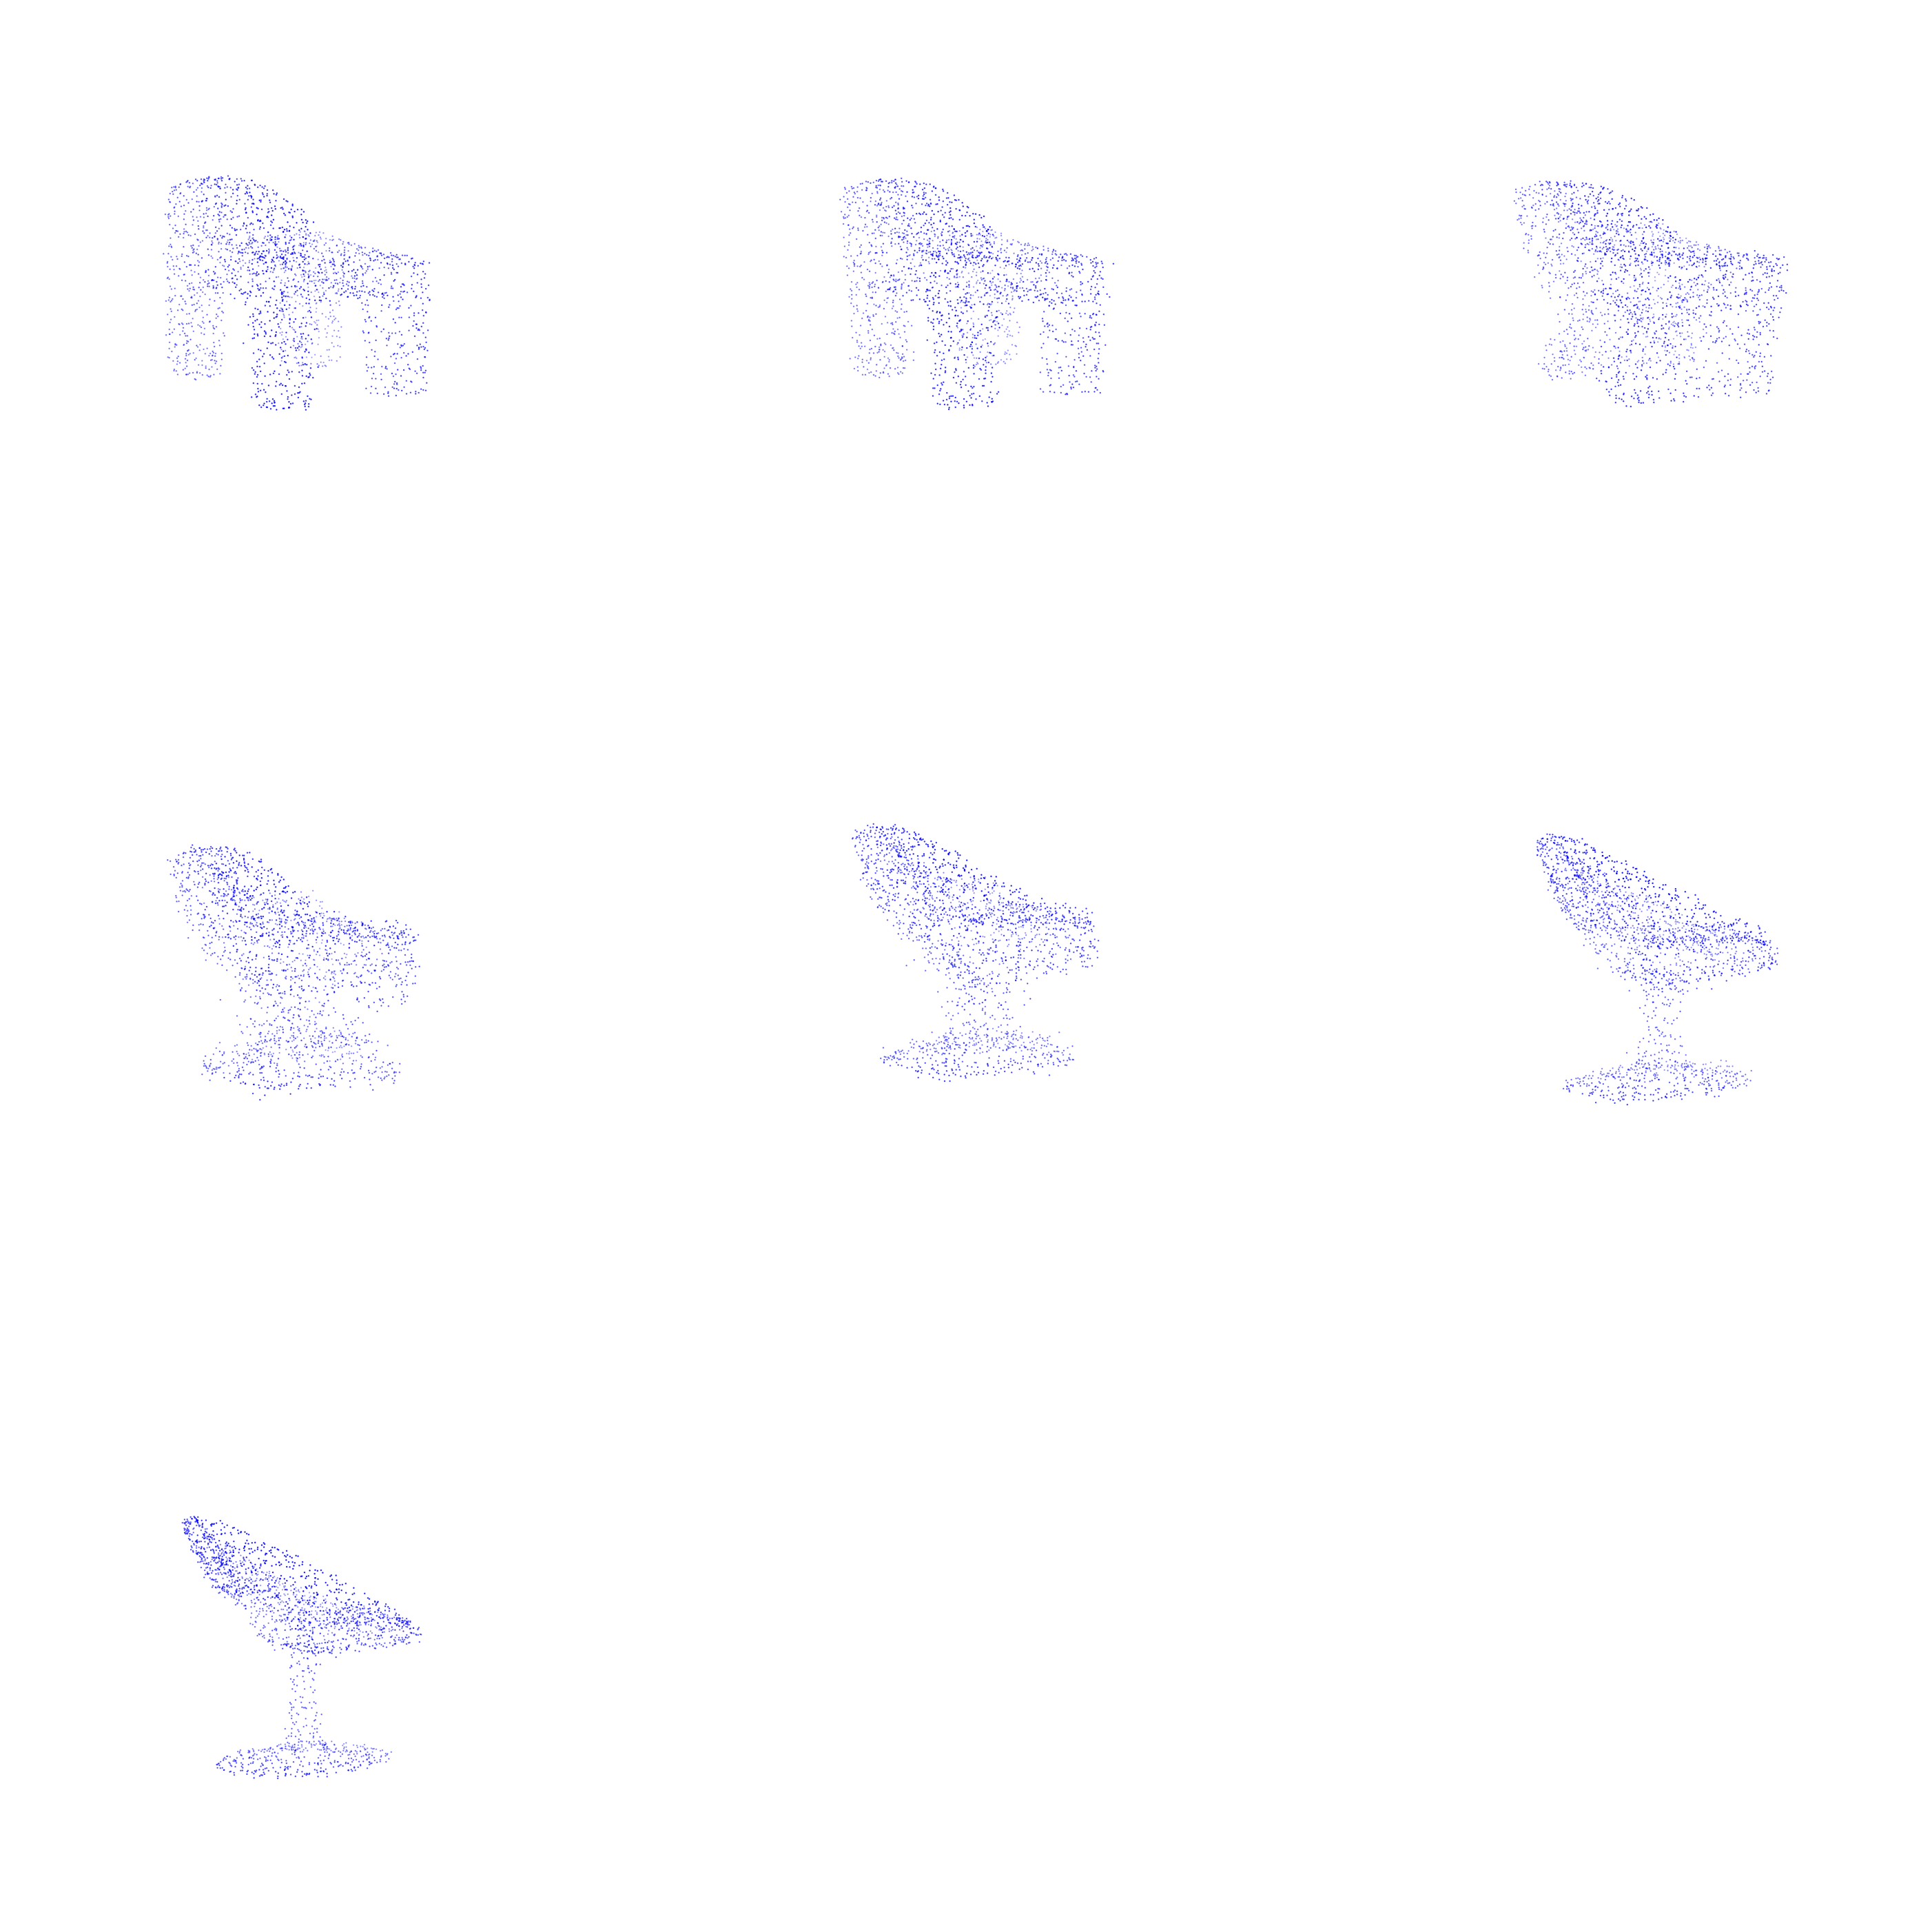

In [17]:
%matplotlib inline


plot_interpolations(ae.interpolate(full_pclouds[0], full_pclouds[10], 5), (3,3) )